<a href="https://colab.research.google.com/github/tanatiem/BADS7601-AI/blob/master/7601_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TO DO**
- save to github
- input files to github

- download to local


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

%cd '/content/drive/My Drive/BADS/7601 AI/project'

/content/drive/My Drive/BADS/7601 AI/project




## Class Definition

In [2]:
# ================================================================
# Graph data structure
# ================================================================
class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}
        self.goal = None

    def add_node(self, node, heuristic=0):
        self.nodes[node] = heuristic
    
    def add_edge(self, n1, n2, cost=0):
        e = (n1, n2) if n1 < n2 else (n2, n1)
        self.edges[e] = cost

    def add_edges(self, edge_list):
        for e in edge_list:
            self.add_edge(*e)
    
    def neighbors(self, node, parent=None):
        nbs = sorted([e[0] if e[1]==node else e[1] for e in g.edges if e[0]==node or e[1]==node])
        if parent:
            nbs = [x for x in nbs if x != parent]
        return nbs

    def get_heuristic(self, n):
        return self.nodes[n]

    def get_cost(self, n1, n2):
        e = (n1, n2) if n1 < n2 else (n2, n1)
        return self.edges[e]

    def set_goal(goal):
        self.goal = goal
        filename = 'in_ucs_hw2.txt'

    def load_file(self, filename):
        self.__init__()
        with open(filename) as f:
            self.goal = next(f).strip()
            for line in f.readlines():
                fields = line.split()
                self.add_node(fields[0], int(fields[1]))
                self.add_edges(list(zip([fields[0]]*len(fields[2::2]), fields[2::2], map(int, fields[3::2]))))

# ================================================================
# Node class used in Search operations
# ================================================================
class Node:
    def __init__(self, id, parent=None, heuristic=0, cost=0, expanded=False):
        self.id = id
        self.parent = parent
        self.heuristic = heuristic
        self.cost = cost
        self.expanded = expanded

        self.eval = heuristic + cost
        
    def __repr__(self):
        return f'({self.id}, {self.parent.id if self.parent else None}, f={self.eval}, g={self.cost}, h={self.heuristic}, xp={self.expanded})'

# ================================================================
# Base class for all Search algorithm classes
# And this is where the codes are shared
# ================================================================
class SearchTree:
    def __init__(self, graph, goal=None):
        self.graph = graph
        self.goal = goal
        self.frontier = []
        self.expand = []
        self.path = []

    def _is_node_expanded(self, node):
        # find if there's any node id and the evaluation function less than f(node)
        return len([ x for x in self.expand if node.id == x.id and self._eval(node) >= self._eval(x) ]) > 0
    
    def _expand_node(self, node):
        children = self.graph.neighbors(node.id, node.parent.id if node.parent else None)
        return [Node(cid, parent=node, heuristic=self.graph.get_heuristic(cid), 
                cost=node.cost + self.graph.get_cost(cid, node.id)) for cid in children]

    def _pop_frontier(self):
        """Pop minimum evaluation function, tie-breaking by node id."""
        min_index = self.frontier.index(min(self.frontier, key=lambda x: (self._eval(x), x.id)))
        return self.frontier.pop(min_index)

    def search(self, start, goal=None):
        # initialize frontier and expand list
        goal = goal if goal else self.goal
        self.frontier.clear()
        self.expand.clear()
        self.path.clear()
        # append start node
        self.frontier.append(Node(start, None, self.graph.get_heuristic(start), 0))

        found = False
        while self.frontier:
            # pop a node from frontier
            n = self._pop_frontier()
            
            # if it's the goal, exit
            if n.id == goal:
                n.expanded = True
                self.expand.append(n)
                found = True
                break;

            # if node is not yet expanded
            if not self._is_node_expanded(n):
                # expand node and store in frontier
                self.frontier.extend(self._expand_node(n))
                n.expanded = True

            self.expand.append(n)

        # wrap-up result in self.path
        if found:
            n = self.expand[-1]
            while n:
                self.path.append(n)
                n = n.parent
            self.path.reverse()

        return found

    # require concrete implementation
    def _eval(self, node):
        return 0

    def _display_node_output(self, node):
        text = f'{self._eval(node):.2f}' if type(self._eval(node))==float else f'{self._eval(node)}'
        text = str(node.id) + '.' + text
        text = text if node.expanded else f'({text})'
        return text

    def get_expand_output(self):
        return ' '.join([self._display_node_output(node) for node in self.expand])

    def get_path_output(self):
        return ' '.join([str(x.id) for x in self.path])

# ================================================================
# Search Implementation
# ================================================================

# A* Search Implementation
class AStarSearch(SearchTree):
    def __init__(self, graph):
        super().__init__(graph, graph.goal)

    def _eval(self, node):
        # Evaluation function = cost + heuristic
        return node.cost + node.heuristic

# Greedy Best-First Search Implementation
class GreedyBestFirstSearch(SearchTree):
    def __init__(self, graph):
        super().__init__(graph, graph.goal)

    def _eval(self, node):
        # Evaluation function = heuristic
        return node.heuristic

# Uniform-Cost Search Implementation
class UniformCostSearch(SearchTree):
    def __init__(self, graph):
        super().__init__(graph)

    def _eval(self, node):
        # Evaluation function = cost
        return node.cost

# ================================================================
# Utility functions
# ================================================================
def create_nxgraph(g): 
    G = nx.Graph()
    G.add_nodes_from([(n,dict(h=h)) for n,h in g.nodes.items()])
    G.add_weighted_edges_from([(*e, w) for e,w in g.edges.items()])
    return G

def draw_graph(G, pos, path=None):
    
    path_nodes = [ n.id for n in path ] if path else []
    path_edges = [ (n.id,n.parent.id) for n in path[1:] ] if path else []

    nx.draw_networkx_nodes(G, pos, node_size=900, node_color='darkturquoise')
    nx.draw_networkx_nodes(G, pos, node_size=900, node_color='tomato', nodelist=path_nodes)

    labels = { x[0] : f"{x[0]}\n{x[1]['h']}" for x in G.nodes(data=True) }
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

    nx.draw_networkx_edges(G, pos, edge_color='lightgray',width=2.5, alpha=.7)
    nx.draw_networkx_edges(G, pos, edge_color='tomato',width=4, edgelist=path_edges)

    edge_labels = { x : G.edges[x]['weight'] for x in G.edges }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)


## Uniformed-Cost Search

### Chapter 3 example

In [ ]:
filename = 'in_ucs_basic.txt'

g = Graph()
g.load_file(filename)
print(f'Cost: {g.edges}')

Cost: {('A', 'B'): 99, ('A', 'C'): 1, ('B', 'E'): 1, ('C', 'D'): 1, ('D', 'E'): 1}


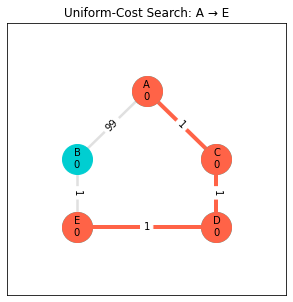

Path:   A C D E
Expand: A.0 C.1 D.2 E.3
Cost:   3


In [ ]:
ucs = UniformCostSearch(g)

start = 'A'
goal = 'E'
ucs.search(start=start, goal=goal)

# Render output
G = create_nxgraph(g)
pos = {'A': (2,3), 'B': (1,2), 'C': (3,2), 'E': (1,1), 'D': (3,1)}

plt.figure(figsize=(5,5))
draw_graph(G, pos, ucs.path)
plt.title(f'Uniform-Cost Search: {start} → {goal}')
plt.xlim((0,4))
plt.ylim((0,4))
plt.show()
print(f'Path:   {ucs.get_path_output()}')
print(f'Expand: {ucs.get_expand_output()}')
print(f'Cost:   {ucs.path[-1].cost}')

### Homework 2

In [ ]:
filename = 'in_ucs_hw2.txt'

g = Graph()
g.load_file(filename)
print(f'Cost: {g.edges}')

Cost: {('A', 'B'): 3, ('A', 'C'): 2, ('A', 'D'): 1, ('B', 'G'): 1, ('C', 'F'): 4, ('D', 'F'): 6, ('F', 'G'): 1}


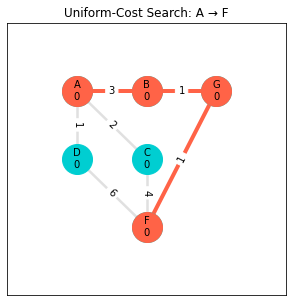

Path:   A B G F
Expand: A.0 D.1 C.2 B.3 G.4 F.5
Cost:   5


In [ ]:
ucs = UniformCostSearch(g)

start = 'A'
goal = 'F'
ucs.search(start=start, goal=goal)

# Render output
G = create_nxgraph(g)
pos = {'A': (1,3), 'B': (2,3), 'C': (2,2), 'D': (1,2), 'F': (2,1),'G': (3,3)}
plt.figure(figsize=(5,5))
draw_graph(G, pos, ucs.path)
plt.title(f'Uniform-Cost Search: {start} → {goal}')
plt.xlim((0,4))
plt.ylim((0,4))
plt.show()
print(f'Path:   {ucs.get_path_output()}')
print(f'Expand: {ucs.get_expand_output()}')
print(f'Cost:   {ucs.path[-1].cost}')

## Greedy Best-First Search

### Chapter 4


In [ ]:
filename = 'in_aStar_chapter4.txt'

g = Graph()
g.load_file(filename)
print(f'Heuristic: {g.nodes}')
print(f'Cost: {g.edges}')

Heuristic: {'A': 79, 'B': 70, 'C': 50, 'D': 53, 'E': 80, 'F': 75, 'G': 60, 'H': 50, 'I': 70, 'J': 40, 'K': 20, 'L': 12, 'M': 20, 'N': 15, 'O': 10, 'P': 30, 'Q': 8, 'X': 0}
Cost: {('A', 'B'): 20, ('A', 'C'): 18, ('A', 'D'): 25, ('B', 'C'): 20, ('B', 'F'): 20, ('B', 'J'): 18, ('C', 'L'): 20, ('C', 'M'): 23, ('D', 'E'): 30, ('D', 'P'): 25, ('F', 'G'): 10, ('F', 'J'): 25, ('H', 'I'): 15, ('H', 'J'): 10, ('J', 'K'): 20, ('M', 'N'): 19, ('M', 'O'): 37, ('M', 'P'): 16, ('N', 'Q'): 30, ('N', 'X'): 26, ('O', 'P'): 22, ('P', 'X'): 30}


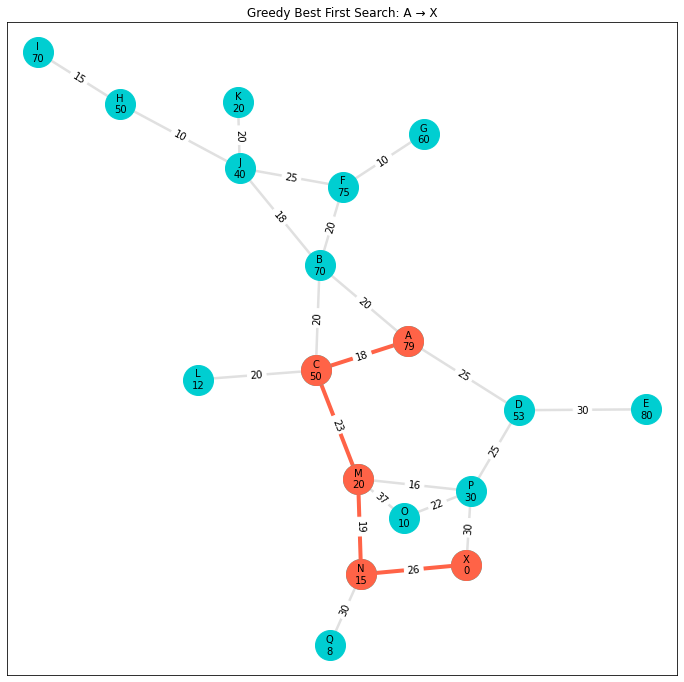

Path:   A C M N X
Expand: A.79 C.50 L.12 M.20 O.10 N.15 X.0
Cost:   86


In [ ]:
G = create_nxgraph(g)
pos = nx.spring_layout(G, k=15, iterations=5000,seed=95, weight=None)

gbf = GreedyBestFirstSearch(g)

start = 'A'
gbf.search(start=start)

plt.figure(figsize=(12,12))
draw_graph(G, pos, gbf.path)
plt.title(f'Greedy Best First Search: {start} → {gbf.goal}')
plt.show()
print(f'Path:   {gbf.get_path_output()}')
print(f'Expand: {gbf.get_expand_output()}')
print(f'Cost:   {gbf.path[-1].cost}')

### Greedy Best First Search : Homework 2

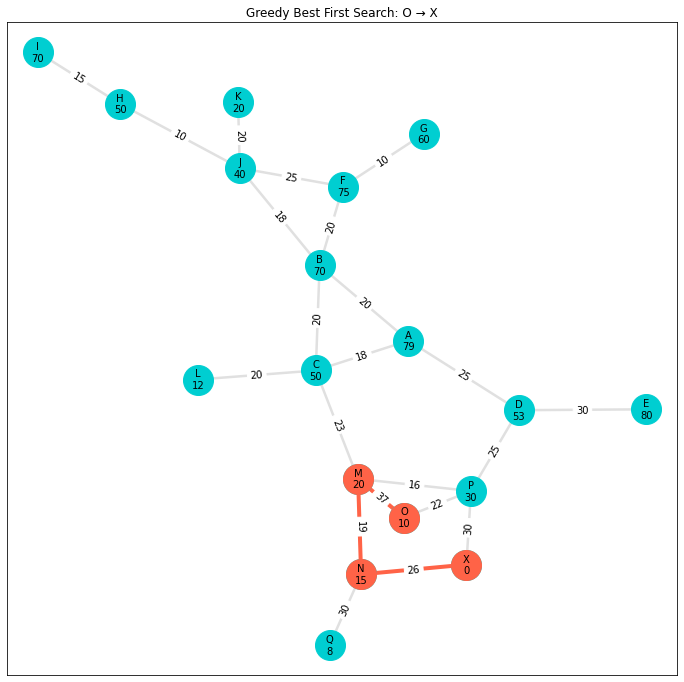

Path:   O M N X
Expand: O.10 M.20 N.15 X.0
Cost:   82


In [ ]:
start = 'O'
gbf.search(start=start)

plt.figure(figsize=(12,12))
draw_graph(G, pos, gbf.path)
plt.title(f'Greedy Best First Search: {start} → {gbf.goal}')
plt.show()
print(f'Path:   {gbf.get_path_output()}')
print(f'Expand: {gbf.get_expand_output()}')
print(f'Cost:   {gbf.path[-1].cost}')

## A* Search

### Chapter 4

In [ ]:
filename = 'in_aStar_chapter4.txt'

g = Graph()
g.load_file(filename)
print(f'Heuristic: {g.nodes}')
print(f'Cost: {g.edges}')

Heuristic: {'A': 79, 'B': 70, 'C': 50, 'D': 53, 'E': 80, 'F': 75, 'G': 60, 'H': 50, 'I': 70, 'J': 40, 'K': 20, 'L': 12, 'M': 20, 'N': 15, 'O': 10, 'P': 30, 'Q': 8, 'X': 0}
Cost: {('A', 'B'): 20, ('A', 'C'): 18, ('A', 'D'): 25, ('B', 'C'): 20, ('B', 'F'): 20, ('B', 'J'): 18, ('C', 'L'): 20, ('C', 'M'): 23, ('D', 'E'): 30, ('D', 'P'): 25, ('F', 'G'): 10, ('F', 'J'): 25, ('H', 'I'): 15, ('H', 'J'): 10, ('J', 'K'): 20, ('M', 'N'): 19, ('M', 'O'): 37, ('M', 'P'): 16, ('N', 'Q'): 30, ('N', 'X'): 26, ('O', 'P'): 22, ('P', 'X'): 30}


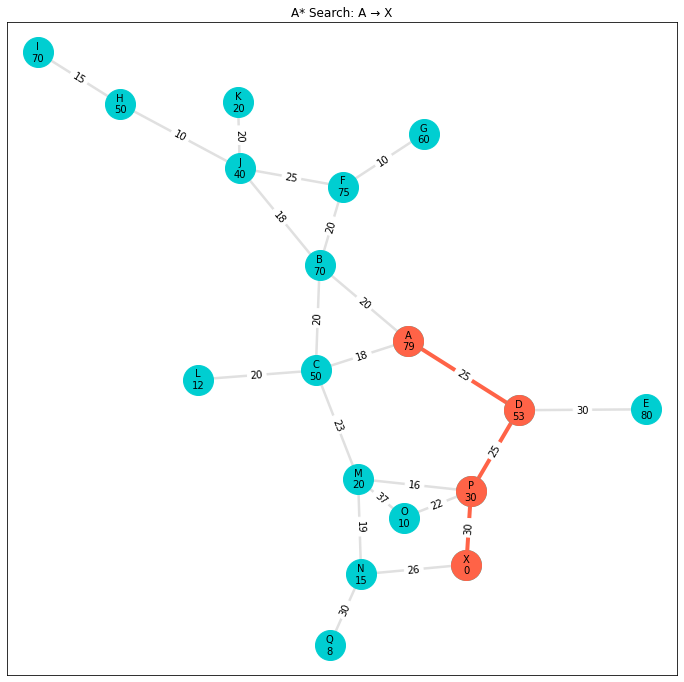

Path:   A D P X
Expand: A.79 C.68 L.50 M.61 N.75 D.78 P.80 X.80


In [ ]:
G = create_nxgraph(g)
pos = nx.spring_layout(G, k=15, iterations=5000,seed=95, weight=None)

astar = AStarSearch(g)

start = 'A'
astar.search(start=start)

plt.figure(figsize=(12,12))
draw_graph(G, pos, astar.path)
plt.title(f'A* Search: {start} → {astar.goal}')
plt.show()
print(f'Path:   {astar.get_path_output()}')
print(f'Expand: {astar.get_expand_output()}')

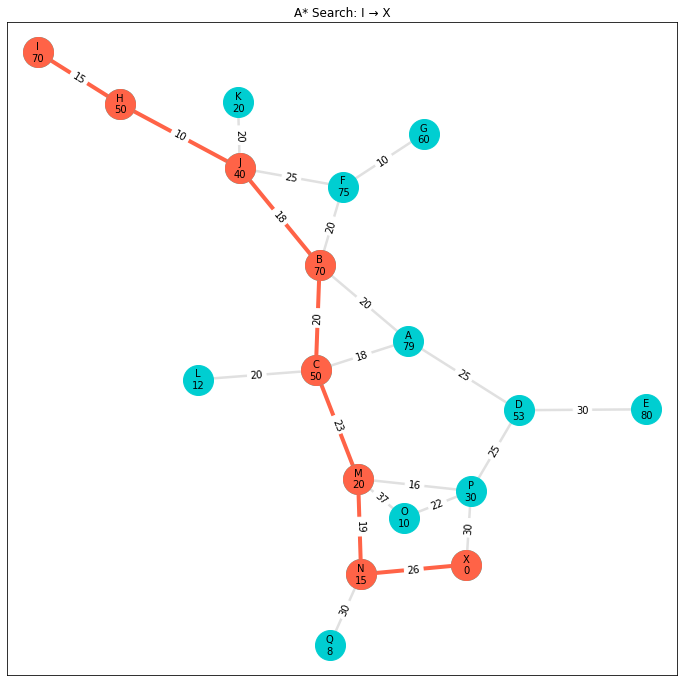

Path:   I H J B C M N X
Expand: I.70 H.65 J.65 K.65 B.113 C.113 L.95 M.106 N.120 F.125 G.120 X.131


In [ ]:
start = 'I'
astar.search(start=start)

plt.figure(figsize=(12,12))
draw_graph(G, pos, astar.path)
plt.title(f'A* Search: {start} → {astar.goal}')
plt.show()
print(f'Path:   {astar.get_path_output()}')
print(f'Expand: {astar.get_expand_output()}')

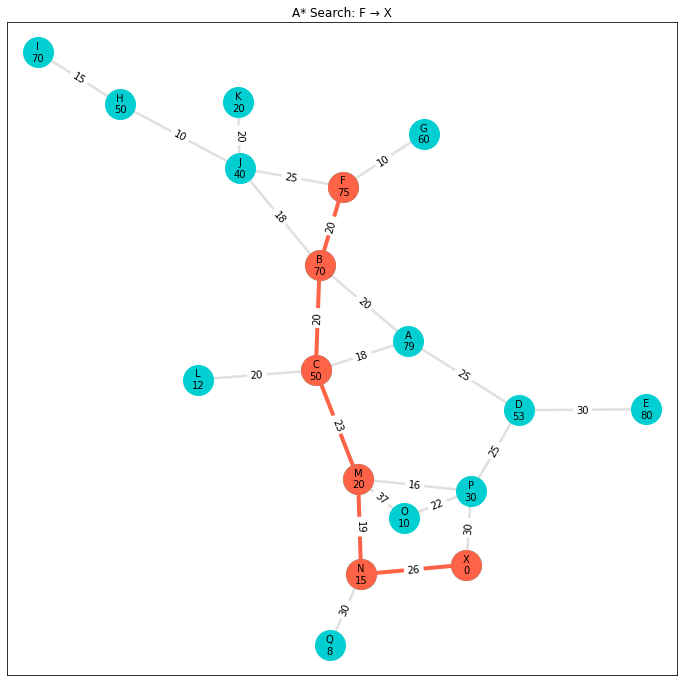

Path:   F B C M N X
Expand: F.75 J.65 K.65 G.70 H.85 B.90 (J.78) C.90 L.72 M.83 N.97 X.108


In [ ]:
start = 'F'
astar.search(start=start)

plt.figure(figsize=(12,12))
draw_graph(G, pos, astar.path)
plt.title(f'A* Search: {start} → {astar.goal}')
plt.show()
print(f'Path:   {astar.get_path_output()}')
print(f'Expand: {astar.get_expand_output()}')

### Given file

In [ ]:
filename = 'in_aStar.txt'

g = Graph()
g.load_file(filename)
print(f'Heuristic: {g.nodes}')
print(f'Cost: {g.edges}')

Heuristic: {'A': 50, 'B': 50, 'C': 40, 'D': 50, 'X': 0}
Cost: {('A', 'B'): 10, ('A', 'C'): 20, ('B', 'D'): 10, ('C', 'D'): 20, ('D', 'X'): 100}


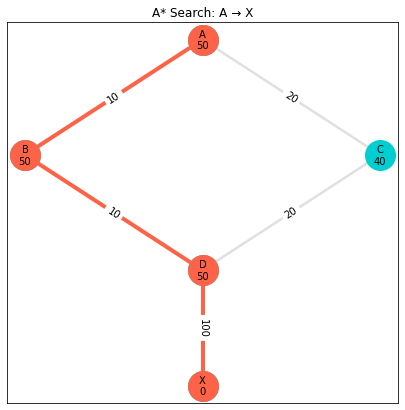

Path:   A B D X
Expand: A.50 B.60 C.60 D.70 (C.80) (D.90) X.120


In [ ]:
G = create_nxgraph(g)
pos={'A':(2,4),'B':(1,3), 'C':(3,3),'D':(2,2), 'X': (2,1)}

astar = AStarSearch(g)

start = 'A'
astar.search(start=start)

plt.figure(figsize=(7,7))
draw_graph(G, pos, astar.path)
plt.title(f'A* Search: {start} → {astar.goal}')
plt.show()
print(f'Path:   {astar.get_path_output()}')
print(f'Expand: {astar.get_expand_output()}')

### Homework 2 - 3

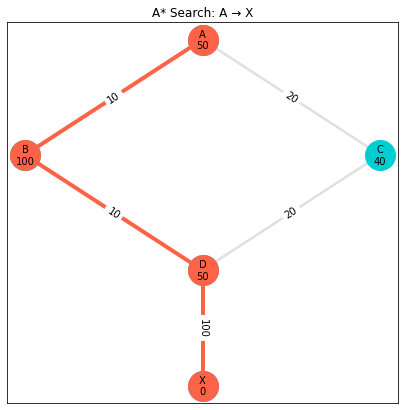

Path:   A B D X
Expand: A.50 C.60 D.90 B.110 D.70 (C.80) X.120


In [ ]:
# tweak heuristic of node B
g.nodes['B'] = 100

G = create_nxgraph(g)
pos={'A':(2,4),'B':(1,3), 'C':(3,3),'D':(2,2), 'X': (2,1)}

start = 'A'
astar.search(start=start)

plt.figure(figsize=(7,7))
draw_graph(G, pos, astar.path)
plt.title(f'A* Search: {start} → {astar.goal}')
plt.show()
print(f'Path:   {astar.get_path_output()}')
print(f'Expand: {astar.get_expand_output()}')

### Homework 2 - 4

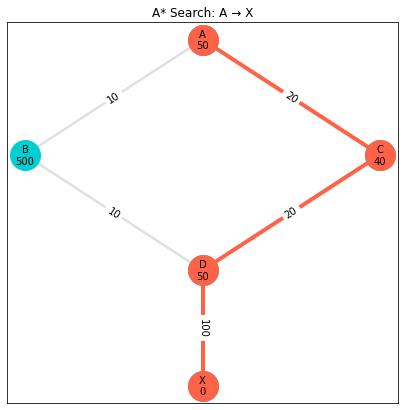

Path:   A C D X
Expand: A.50 C.60 D.90 X.140


In [ ]:
g.nodes['B'] = 500

G = create_nxgraph(g)
pos={'A':(2,4),'B':(1,3), 'C':(3,3),'D':(2,2), 'X': (2,1)}

start = 'A'
astar.search(start=start)

plt.figure(figsize=(7,7))
draw_graph(G, pos, astar.path)
plt.title(f'A* Search: {start} → {astar.goal}')
plt.show()
print(f'Path:   {astar.get_path_output()}')
print(f'Expand: {astar.get_expand_output()}')

### Own graph

In [71]:
filename = 'in_aStar_home_to_NIDA_distance.txt'

g = Graph()
g.load_file(filename)
print(f'# Nodes:   {len(g.nodes)}')
print(f'# Edges:   {len(g.edges)}')
print(f'Heuristic: {g.nodes}')
print(f'Cost: {g.edges}')

# Nodes:   15
# Edges:   21
Heuristic: {'A': 7960, 'X': 8000, 'B': 7270, 'C': 8690, 'D': 8850, 'E': 8800, 'F': 7890, 'G': 5170, 'H': 5600, 'I': 6850, 'J': 4360, 'K': 1050, 'L': 1250, 'Y': 570, 'M': 0}
Cost: {('A', 'B'): 800, ('A', 'X'): 750, ('C', 'X'): 700, ('F', 'X'): 1500, ('B', 'E'): 1800, ('B', 'H'): 1700, ('C', 'D'): 1300, ('C', 'E'): 1800, ('D', 'F'): 1000, ('E', 'I'): 3000, ('F', 'G'): 3100, ('G', 'H'): 3800, ('G', 'K'): 4500, ('H', 'I'): 2000, ('H', 'J'): 1800, ('I', 'J'): 3000, ('J', 'L'): 3300, ('K', 'L'): 350, ('K', 'M'): 1500, ('L', 'Y'): 1400, ('M', 'Y'): 800}


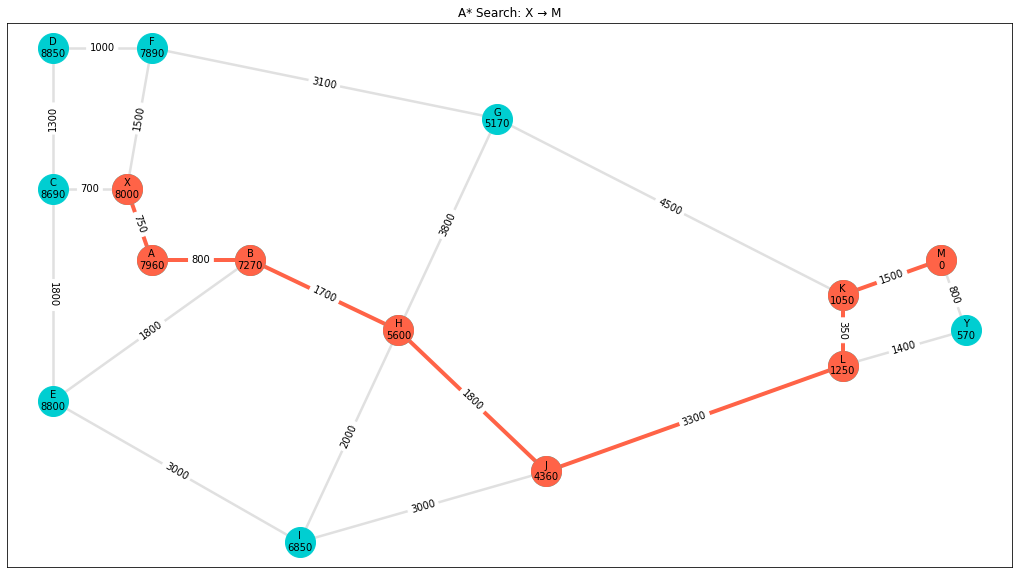

Path:   X A B H J L K M
Expand: X.8000 A.8710 B.8820 H.8850 C.9390 F.9390 J.9410 L.9600 K.9750 G.9770 (K.10150) M.10200


In [78]:
G = create_nxgraph(g)
# pos = nx.spring_layout(G, k=15, iterations=5000, seed=43, pos={'A':(2,2),'M':(5,1)})
pos = { 'A': (3,6), 'B':(5,6), 'X':(2.5,7), 'C':(1,7), 'D':(1,9), 'E': (1,4), 'F': (3,9), 'G': (10,8), 'H':(8,5),'I':(6,2), 'J':(11,3), 'K':(17,5.5),'L':(17,4.5),'M':(19,6),'Y':(19.5,5)}

astar = AStarSearch(g)

start = 'X'
astar.search(start=start)

plt.figure(figsize=(18,10))
draw_graph(G, pos, astar.path)
plt.title(f'A* Search: {start} → {astar.goal}')
plt.show()
print(f'Path:   {astar.get_path_output()}')
print(f'Expand: {astar.get_expand_output()}')

In [80]:
filename = 'in_aStar_home_to_NIDA_time.txt'

g = Graph()
g.load_file(filename)
print(f'# Nodes:   {len(g.nodes)}')
print(f'# Edges:   {len(g.edges)}')
print(f'Heuristic: {g.nodes}')
print(f'Cost: {g.edges}')

# Nodes:   15
# Edges:   21
Heuristic: {'A': 478, 'X': 480, 'B': 436, 'C': 521, 'D': 531, 'E': 528, 'F': 473, 'G': 310, 'H': 336, 'I': 411, 'J': 262, 'K': 63, 'L': 75, 'Y': 34, 'M': 0}
Cost: {('A', 'B'): 180, ('A', 'X'): 120, ('C', 'X'): 120, ('F', 'X'): 240, ('B', 'E'): 180, ('B', 'H'): 420, ('C', 'D'): 120, ('C', 'E'): 480, ('D', 'F'): 180, ('E', 'I'): 840, ('F', 'G'): 780, ('G', 'H'): 480, ('G', 'K'): 960, ('H', 'I'): 120, ('H', 'J'): 240, ('I', 'J'): 540, ('J', 'L'): 600, ('K', 'L'): 120, ('K', 'M'): 240, ('L', 'Y'): 240, ('M', 'Y'): 60}


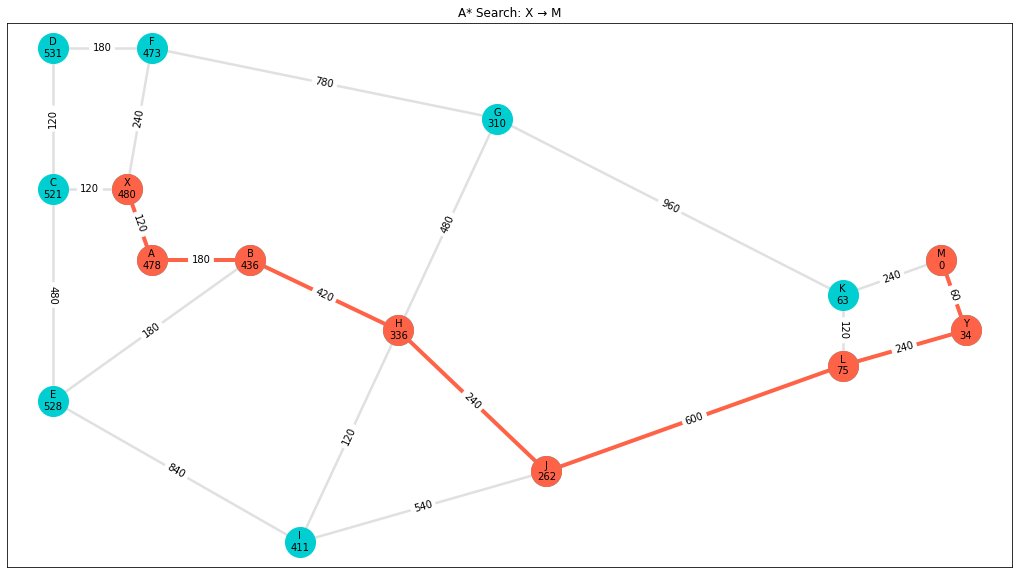

Path:   X A B H J L Y M
Expand: X.480 A.598 C.641 F.713 B.736 D.771 (F.893) (D.951) E.1008 H.1056 (E.1128) J.1222 I.1251 G.1330 (C.1481) (G.1510) L.1635 (J.1642) (I.1731) K.1743 Y.1834 (H.1836) M.1860


In [81]:
G = create_nxgraph(g)
pos = { 'A': (3,6), 'B':(5,6), 'X':(2.5,7), 'C':(1,7), 'D':(1,9), 'E': (1,4), 'F': (3,9), 'G': (10,8), 'H':(8,5),'I':(6,2), 'J':(11,3), 'K':(17,5.5),'L':(17,4.5),'M':(19,6),'Y':(19.5,5)}


astar = AStarSearch(g)

start = 'X'
astar.search(start=start)

plt.figure(figsize=(18,10))
draw_graph(G, pos, astar.path)
plt.title(f'A* Search: {start} → {astar.goal}')
plt.show()
print(f'Path:   {astar.get_path_output()}')
print(f'Expand: {astar.get_expand_output()}')